In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, os
from pathlib import Path
import random
import cv2

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3

In [2]:
path = "/home/nvinhhung/nvidia/data/faceEmotions"
classes = sorted(os.listdir(path))
classes

['anger', 'disgust', 'fear', 'happy', 'pain', 'sad']

In [3]:
anger_path = "/home/nvinhhung/nvidia/data/faceEmotions/anger"
disgust_path = "/home/nvinhhung/nvidia/data/faceEmotions/disgust"
fear_path = "/home/nvinhhung/nvidia/data/faceEmotions/fear"
happy_path = "/home/nvinhhung/nvidia/data/faceEmotions/happy"
pain_path = "/home/nvinhhung/nvidia/data/faceEmotions/pain"
sad_path = "/home/nvinhhung/nvidia/data/faceEmotions/sad"

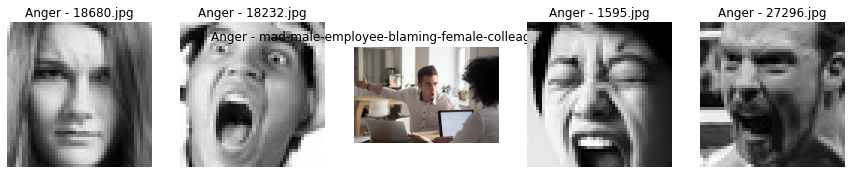

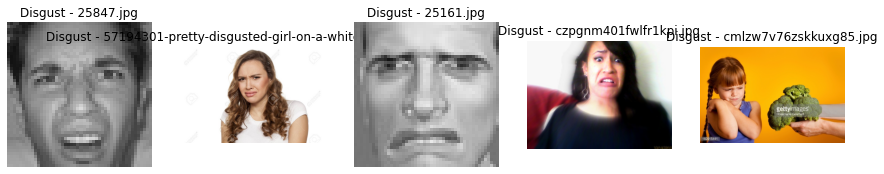

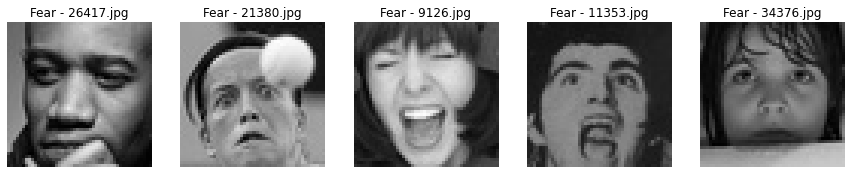

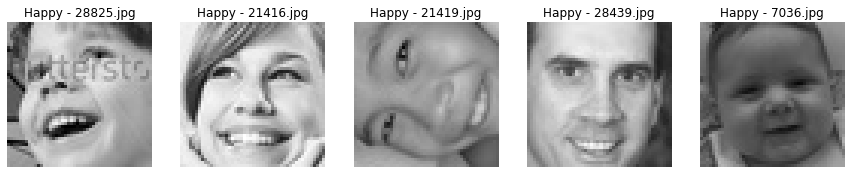

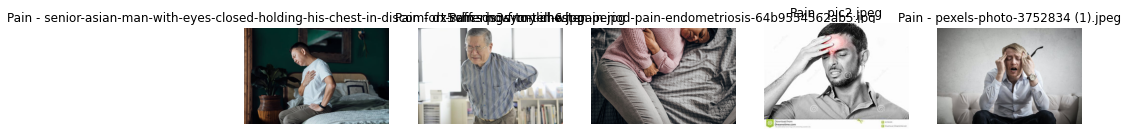

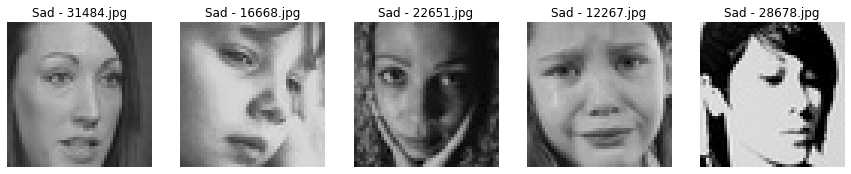

In [4]:
def load_sample_images(folder_path, num_samples=5):
    sample_images = []
    for root, dirs, files in os.walk(folder_path):
        for i, file in enumerate(files):
            if i >= num_samples:
                break
            image_path = os.path.join(root, file)
            image = Image.open(image_path)
            image = image.convert('RGB')
            sample_images.append((file, image))
    return sample_images

def display_sample_images(sample_images, label):
    plt.figure(figsize=(15, 3))
    for i, (file, image) in enumerate(sample_images):
        plt.subplot(1, len(sample_images), i + 1)
        plt.imshow(image)
        plt.title(f"{label} - {file}")
        plt.axis("off")
    plt.show()

anger_samples = load_sample_images(anger_path)
display_sample_images(anger_samples, 'Anger')


disgust_samples = load_sample_images(disgust_path)
display_sample_images(disgust_samples, 'Disgust')


fear_samples = load_sample_images(fear_path)
display_sample_images(fear_samples, 'Fear')

happy_samples = load_sample_images(happy_path)
display_sample_images(happy_samples, 'Happy')

pain_samples = load_sample_images(pain_path)
display_sample_images(pain_samples, 'Pain')

sad_samples = load_sample_images(sad_path)
display_sample_images(sad_samples, 'Sad')

In [5]:
def dataset_statistics(folder_path):
    class_counts = {}
    for root, dirs, files in os.walk(folder_path):
        if files:
            class_name = os.path.basename(root)
            class_counts[class_name] = len(files)
    return class_counts

input_folder = [anger_path, fear_path, disgust_path, happy_path, pain_path, sad_path]
print("Dataset Statistics:")
for input in input_folder:
  dataset_stats = dataset_statistics(input)
  for class_name, count in dataset_stats.items():
      print(f"{class_name}: {count} images")

Dataset Statistics:
anger: 5272 images
fear: 5303 images
disgust: 767 images
happy: 9338 images
pain: 174 images
sad: 6399 images


In [6]:
for filename in os.listdir(anger_path):
    if (filename.endswith(ext) for ext in ['.jpeg', '.png', '.gif']):
        prefix = os.path.splitext(filename)[0]
        os.rename(os.path.join(anger_path, filename), os.path.join(anger_path, prefix+'.jpg'))
    else:
        continue

for filename in os.listdir(disgust_path):
    if (filename.endswith(ext) for ext in ['.jpeg', '.png', '.gif']):
        prefix = os.path.splitext(filename)[0]
        os.rename(os.path.join(disgust_path, filename), os.path.join(disgust_path, prefix+'.jpg'))
    else:
        continue
for filename in os.listdir(fear_path):
    if (filename.endswith(ext) for ext in ['.jpeg', '.png', '.gif']):
        prefix = os.path.splitext(filename)[0]
        os.rename(os.path.join(fear_path, filename), os.path.join(fear_path, prefix+'.jpg'))
    else:
        continue

for filename in os.listdir(happy_path):
    if (filename.endswith(ext) for ext in ['.jpeg', '.png', '.gif']):
        prefix = os.path.splitext(filename)[0]
        os.rename(os.path.join(happy_path, filename), os.path.join(happy_path, prefix+'.jpg'))
    else:
        continue
for filename in os.listdir(pain_path):
    if (filename.endswith(ext) for ext in ['.jpeg', '.png', '.gif']):
        prefix = os.path.splitext(filename)[0]
        os.rename(os.path.join(pain_path, filename), os.path.join(pain_path, prefix+'.jpg'))
    else:
        continue

for filename in os.listdir(sad_path):
    if (filename.endswith(ext) for ext in ['.jpeg', '.png', '.gif']):
        prefix = os.path.splitext(filename)[0]
        os.rename(os.path.join(sad_path, filename), os.path.join(sad_path, prefix+'.jpg'))
    else:
        continue

In [7]:
def to_frame(path):
    class_types = []
    class_paths = []
    files = os.listdir(path)
    for file in files:
        label_dir = os.path.join(path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            class_name = os.path.splitext(file)[0]
            class_types.append(class_name)
    image_classes = pd.Series(class_types, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    df = pd.concat([image_paths, image_classes], axis=1)
    return df

In [8]:
df = to_frame(path)

In [9]:
df

,Class Path,Class
0,/home/nvinhhung/nvidia/data/faceEmotions/pain/...,pain
1,/home/nvinhhung/nvidia/data/faceEmotions/pain/...,pain
2,/home/nvinhhung/nvidia/data/faceEmotions/pain/...,pain
3,/home/nvinhhung/nvidia/data/faceEmotions/pain/...,pain
4,/home/nvinhhung/nvidia/data/faceEmotions/pain/...,pain
...,...,...
27248,/home/nvinhhung/nvidia/data/faceEmotions/sad/1...,sad
27249,/home/nvinhhung/nvidia/data/faceEmotions/sad/c...,sad
27250,/home/nvinhhung/nvidia/data/faceEmotions/sad/2...,sad
27251,/home/nvinhhung/nvidia/data/faceEmotions/sad/2...,sad


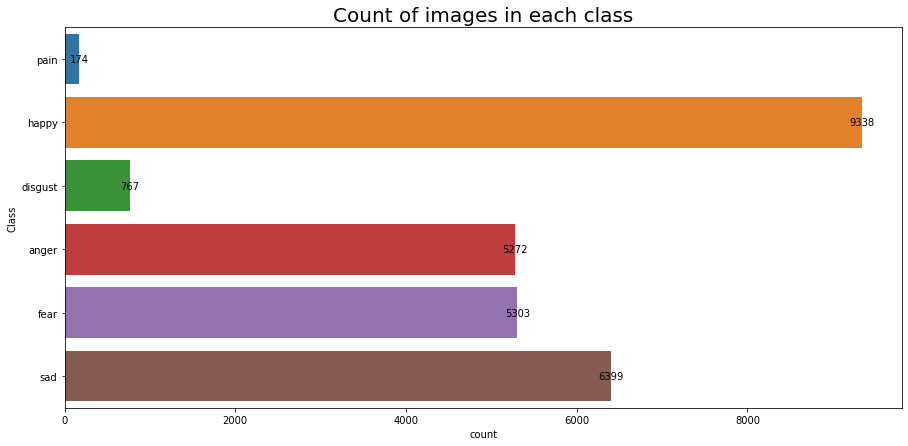

In [10]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=df, y='Class')
plt.title('Count of images in each class', fontsize=20)

# Add labels for each bar
for p in ax.patches:
    ax.text(p.get_width() + 1, p.get_y() + p.get_height()/2, 
            int(p.get_width()), 
            ha='center', va='center')

plt.show()

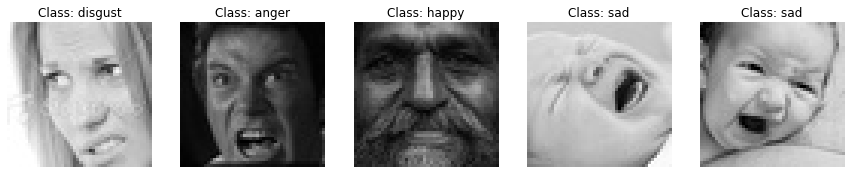

In [11]:
def display_random_images(df, num_images=5):
    random_indices = random.sample(range(len(df)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(random_indices):
        image_path = df.loc[idx, 'Class Path']
        class_name = df.loc[idx, 'Class']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {class_name}')
        axes[i].axis('off')
    plt.show()

display_random_images(df)

In [12]:
train_df, test_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 20)
valid_df, test_df = train_test_split(test_df,  train_size= 0.5, shuffle= True, random_state= 20)

In [13]:
valid_df

,Class Path,Class
8845,/home/nvinhhung/nvidia/data/faceEmotions/happy...,happy
11132,/home/nvinhhung/nvidia/data/faceEmotions/anger...,anger
4110,/home/nvinhhung/nvidia/data/faceEmotions/happy...,happy
17390,/home/nvinhhung/nvidia/data/faceEmotions/fear/...,fear
4814,/home/nvinhhung/nvidia/data/faceEmotions/happy...,happy
...,...,...
5662,/home/nvinhhung/nvidia/data/faceEmotions/happy...,happy
24777,/home/nvinhhung/nvidia/data/faceEmotions/sad/2...,sad
21069,/home/nvinhhung/nvidia/data/faceEmotions/sad/3...,sad
7552,/home/nvinhhung/nvidia/data/faceEmotions/happy...,happy


In [14]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1.0/299, brightness_range=(0.8, 1.2),
                          rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                          shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
                          fill_mode='nearest')

valid_test_datagen = ImageDataGenerator(rescale=1.0/299)

train_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = valid_test_datagen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_gen = valid_test_datagen.flow_from_dataframe(df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, shuffle=False)

Found 19077 validated image filenames belonging to 6 classes.
Found 4088 validated image filenames belonging to 6 classes.
Found 27253 validated image filenames belonging to 6 classes.


In [15]:
# model.summary()

img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(512,activation= 'relu'),
    Dropout(rate= 0.40),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(6, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [16]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Đường dẫn để lưu các mô hình
checkpoint_path = "best_model_2.keras"  # Đổi từ .h5 sang .keras

# Sử dụng ModelCheckpoint để lưu mô hình tốt nhất dựa trên độ chính xác của tập validation
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy', # Hoặc 'val_loss' nếu muốn theo dõi loss
                             save_best_only=True, # Chỉ lưu mô hình tốt nhất
                             mode='max',          # 'max' nếu theo dõi accuracy, 'min' nếu theo dõi loss
                             verbose=1)

# Huấn luyện mô hình với callback
hist = model.fit(train_gen,
                 epochs=25,
                 validation_data=valid_gen,
                 shuffle=False,
                 callbacks=[checkpoint])  # Thêm callback vào đây

# Sau khi huấn luyện xong, bạn có thể load lại mô hình tốt nhất:
from tensorflow.keras.models import load_model
best_model = load_model(checkpoint_path)


Epoch 1/25
597/597 [==============================] - 2997s 5s/step - loss: 1.2434 - accuracy: 0.4631 - precision_1: 0.7432 - recall_1: 0.2438 - val_loss: 0.9308 - val_accuracy: 0.6248 - val_precision_1: 0.8131 - val_recall_1: 0.4320

Epoch 00001: val_accuracy improved from -inf to 0.62476, saving model to best_model_2.keras
Epoch 2/25
597/597 [==============================] - 2978s 5s/step - loss: 0.9605 - accuracy: 0.6224 - precision_1: 0.7625 - recall_1: 0.4543 - val_loss: 0.9212 - val_accuracy: 0.6363 - val_precision_1: 0.7259 - val_recall_1: 0.5357

Epoch 00002: val_accuracy improved from 0.62476 to 0.63625, saving model to best_model_2.keras
Epoch 3/25
597/597 [==============================] - 2977s 5s/step - loss: 0.8572 - accuracy: 0.6664 - precision_1: 0.7794 - recall_1: 0.5348 - val_loss: 0.8233 - val_accuracy: 0.6822 - val_precision_1: 0.7863 - val_recall_1: 0.5741

Epoch 00003: val_accuracy improved from 0.63625 to 0.68224, saving model to best_model_2.keras
Epoch 4/25
59

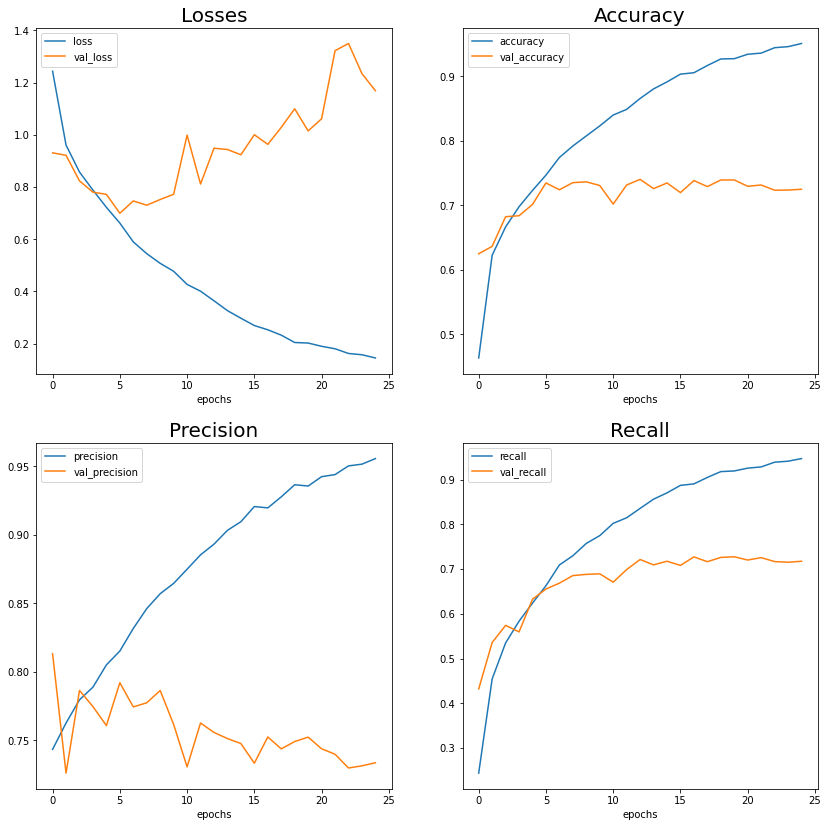

In [18]:
plt.figure(figsize=(14, 14))

# Losses
plt.subplot(2, 2, 1)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

# Precision
plt.subplot(2, 2, 3)
plt.plot(hist.history['precision_1'], label='precision')
plt.plot(hist.history['val_precision_1'], label='val_precision')
plt.title('Precision', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

# Recall
plt.subplot(2, 2, 4)
plt.plot(hist.history['recall_1'], label='recall')
plt.plot(hist.history['val_recall_1'], label='val_recall')
plt.title('Recall', fontsize=20)
plt.xlabel('epochs')
plt.legend(loc="upper left")

plt.show()

In [19]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

852/852 [==============================] - 749s 878ms/step - loss: 0.4208 - accuracy: 0.8930 - precision_1: 0.8976 - recall_1: 0.8898
Train Loss:  0.16268163919448853
Train Accuracy:  0.9385647773742676
--------------------
Validation Loss:  1.1687698364257812
Validation Accuracy:  0.7248042821884155
--------------------
Test Loss:  0.42079710960388184
Test Accuracy:  0.8929659128189087
